In [1]:
import pickle
with open("vonMisesData_100neurons.p", "rb") as input_file:
    [NumNeurons, NeuronParameters, WorldParameters, Neurons, 
         NumTrajectories, TrajStartPos, RatRadialSpeed, TrajLength, SpikeRasters] = pickle.load(input_file)

In [2]:
# All imports here...
import numpy as np

import time

from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# display place field coverage of a particular environment
sns.set(rc={'figure.figsize': (18, 4),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
def BinSpikeRasters(Rasters, BinWidth=0.25, NBins=0) :
    # Rasters is a list of ndarrays, where each array contains spike times for a neuron
    if (NBins == 0) :
        b = 0.0;
        for spk_ts in Rasters :
            if (len(spk_ts) > 0) :
                b = max(b, (spk_ts[-1] / BinWidth))
        NBins = np.int(np.ceil(b))
    BinnedRasters = np.zeros((NBins, len(Rasters)), dtype=int)
    
    for k, spk_ts in enumerate(Rasters) :
        for s in spk_ts :
            BinnedRasters[np.int(s/BinWidth), k] += 1
    return BinnedRasters

In [4]:

t0 = time.time();
# Train model with first environment
NTrain = 90
NTest = 10
BinWidth = 0.25 # 250 ms bins
NBins = np.int(TrajLength / BinWidth)
TrainingData = []
TrainingDataT = []
for w in range(WorldParameters['NEnv']) :
    TrainingData.append([])
    TrainingDataT.append([])

    for k in range(NTrain) :
        d = BinSpikeRasters(SpikeRasters[w][k], BinWidth=BinWidth, NBins=NBins)
        TrainingData[w].append(d)
        TrainingDataT[w].append(d.T)
        t1 = time.time();
print("Time elapsed for binning: ", t1-t0)




Time elapsed for binning:  0.3785691261291504


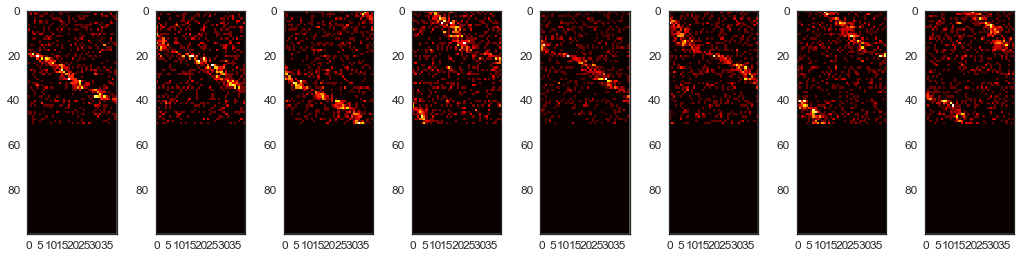

In [5]:
f, axarr = plt.subplots(1,8)
for k in range(8):
    plt.sca(axarr[k])
    plt.imshow(TrainingData[0][k].T, interpolation="none",cmap="hot")

In [6]:
StackedTrainingData = []
TrainingSequenceLengths = []
for w in range(WorldParameters['NEnv']) :
    StackedTrainingData.append(np.vstack(TrainingData[w]))
    TrainingSequenceLengths.append(np.zeros(NTrain, dtype=int))
    for idx,l in enumerate(TrainingData[w]) :
        (TrainingSequenceLengths[w][idx], ncols) = l.shape


In [7]:
from bayespy.nodes import Dirichlet
from bayespy.nodes import Categorical
from bayespy.nodes import CategoricalMarkovChain
from bayespy.nodes import Mixture
from bayespy.inference import VB
from bayespy.nodes import Poisson, Gaussian, Wishart, Gamma

K = 25 # >> K
D=NumNeurons



In [8]:
# Mixture of Poisson model for both simple mixture and HMM
beta = 100

from scipy.cluster.vq import vq, kmeans
(kmeans_clusters,distortion) = kmeans(StackedTrainingData[0].astype(float),K)

alpha = np.mean(kmeans_clusters) * beta


In [9]:


rate_prior = Gamma(alpha, beta, plates=(D,1,K))
rate_prior.initialize_from_value(np.expand_dims(kmeans_clusters.T + 1e-3,axis=1))


initial_state = Dirichlet(1e-3*np.ones(K))
transmat = Dirichlet(1e-3*np.ones((K,K)))

Y = []
Z = []
for i in range(len(TrainingData[0])):
    [nstates,nneurons]=TrainingData[0][i].shape
    Z.append(CategoricalMarkovChain(initial_state, transmat, states=nstates))
    Y.append(Mixture(Z[i], Poisson, rate_prior))
    Y[i].observe(TrainingData[0][i].T)


nodes = Y + Z + [rate_prior, transmat, initial_state]

Q = VB(*nodes)

In [10]:
Q.set_annealing(0.8)
Q.update(repeat=100, tol=1e-2)
Q.set_annealing(0.9)
Q.update(repeat=100, tol=1e-2)
Q.set_annealing(1)
Q.update(repeat=100, tol=1e-2)





Iteration 1: loglike=-1.891999e+05 (0.828 seconds)
Iteration 2: loglike=-1.844639e+05 (0.820 seconds)
Iteration 3: loglike=-1.814201e+05 (0.919 seconds)
Iteration 4: loglike=-1.787010e+05 (0.883 seconds)
Iteration 5: loglike=-1.765196e+05 (0.851 seconds)
Iteration 6: loglike=-1.755400e+05 (0.827 seconds)
Converged at iteration 6.
Iteration 7: loglike=-1.757159e+05 (0.794 seconds)
Iteration 8: loglike=-1.756544e+05 (0.811 seconds)
Converged at iteration 8.
Iteration 9: loglike=-1.760780e+05 (0.810 seconds)
Iteration 10: loglike=-1.760329e+05 (0.849 seconds)
Converged at iteration 10.


/Users/ckemere/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


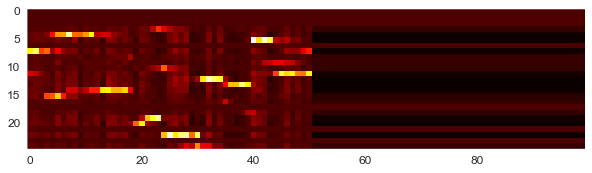

In [16]:
mm = rate_prior.get_moments()
sns.set(rc={'figure.figsize': (10, 5),'lines.linewidth': 2, 'font.size': 18, 'axes.labelsize': 16, 'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style('dark')
plt.imshow(mm[0].squeeze().T, interpolation="none", cmap="hot")

In [12]:
initial_state.show()

 ~ Dirichlet(alpha)
  alpha =
[  1.00000000e-03   1.00000000e-03   1.00000000e-03   1.00000000e-03
   2.71485006e+00   7.64271705e+00   1.00000000e-03   8.93984268e+00
   1.00000000e-03   1.00000000e-03   1.00000000e-03   3.96888495e+00
   6.00331013e+00   1.69955165e+01   7.42028300e+00   3.32009587e+00
   1.00000000e-03   1.00000000e-03   1.00000000e-03   1.06984057e+01
   1.39175457e+01   1.00000000e-03   8.38954842e+00   1.00000000e-03
   1.00000000e-03]


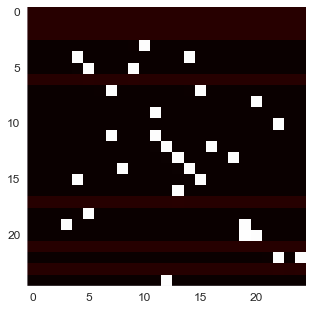

In [17]:
Am = transmat.get_moments()
plt.imshow(Am[0].squeeze(), interpolation="none", cmap="hot")